In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.3.0.dev20231123


2023-12-08 13:11:57,999	INFO worker.py:1538 -- Started a local Ray instance.


In [3]:
from secretflow.ml.nn.utils import BaseModule, TorchModel
from secretflow.ml.nn.fl.utils import metric_wrapper, optim_wrapper
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F

2023-12-08 13:12:00.577814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-08 13:12:01.237087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-08 13:12:01.237142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-08 13:12:01.237147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [4]:
import torch
class Model(BaseModule):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU()
        )
        self.head = nn.Linear(200, 10)
        self.cg = []
        self.c =[]
        for param in self.parameters():
            self.cg.append(torch.zeros_like(param))
            self.c.append(torch.zeros_like(param))
        self.eta_l = 0.01
    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x
class TwoLayerNN(BaseModule):
    def __init__(self):
        super(TwoLayerNN, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.head = nn.Linear(200, 10)
    def forward(self, x):
        x = nn.Flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU(x)
        x = self.fc2(x)
        x = nn.ReLU(x)
        x = self.head(x)
        return x


In [5]:
from typing import Dict, List, Tuple, Union
import numpy as np

from secretflow.data.ndarray import FedNdarray, PartitionWay
from secretflow.device.device.pyu import PYU

from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

def load_emnist(
        parts: Union[List[PYU], Dict[PYU, Union[float, Tuple]]],
        batch_size: int = 1,
        is_torch: bool = True,
        num_classes_per_client=4,
) -> Tuple[Tuple[FedNdarray, FedNdarray], Tuple[FedNdarray, FedNdarray]]:
    """Load EMNIST dataset to federated ndarrays.

    Args:
        parts: the data partitions.
        batch_size: Batch size for the DataLoader.
        is_torch: optional, return torch tensors if True. Default to True.

    Returns:
        A tuple consists of two tuples, (x_train, y_train) and (x_test, y_test).
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # 加载 CIFAR-10 训练集和测试集
    trainset = EMNIST(root='./data', train=True, split='mnist', download=True, transform=transform)
    testset = EMNIST(root='./data', train=False, split='mnist', download=True, transform=transform)

    # 使用 DataLoader 进行批处理
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    # 将 DataLoader 转换为 SecretFlow 可处理的格式
    # 注意: 这里需要根据 SecretFlow 的要求进行适当的转换
    train_data, train_labels = _convert_to_fedndarray(trainloader, parts, is_torch)
    test_data, test_labels = _convert_to_fedndarray(testloader, parts, is_torch)

    return ((train_data, train_labels), (test_data, test_labels))

def _convert_to_fedndarray(dataloader, parts, is_torch):
    data_list = []
    label_list = []
    for data, label in dataloader:
        if is_torch:
            data = data.numpy()
            label = label.numpy()
        data_list.append(data)
        label_list.append(label)
    data_list, label_list = np.concatenate(data_list), np.concatenate(label_list)
    return create_emnist_ndarray(data_list, label_list, parts=parts, is_torch=is_torch)

def create_emnist_ndarray(data, labels, parts, is_torch=False, num_classes_per_client=4):
    assert len(data) == len(labels), "Data and labels must have the same length"
    class_indices = {i: np.where(labels == i)[0] for i in range(10)}

    # 分配给每个 PYU 的类别
    pyu_classes = {}
    total_samples = len(data)
    for idx, pyu in enumerate(parts.keys()):
        np.random.seed(idx)
        pyu_classes[pyu] = np.random.choice(10, num_classes_per_client, replace=False)  # 随机选择 4 个类别

    # 分配数据和标签给每个 PYU
    pyu_data = {}
    pyu_labels = {}
    for pyu, proportion in parts.items():
        pyu_sample_size = int(total_samples * proportion)  # 计算每个 PYU 的样本量
        # 为每个 PYU 从选定的类别中采样数据
        indices = np.concatenate(
            [np.random.choice(class_indices[cls], size=pyu_sample_size // num_classes_per_client, replace=True) for cls
             in pyu_classes[pyu]])
        np.random.shuffle(indices)  # 打乱索引
        pyu_data[pyu] = data[indices]
        pyu_labels[pyu] = labels[indices]
        print(len(pyu_data[pyu]), pyu_classes[pyu],pyu_labels[pyu][0])  # 打印每个PYU的数据量和随机类别

    # 将数据和标签转换为 FedNdarray
    data_fedndarray = FedNdarray(
        partitions={
            pyu: pyu(lambda arr: arr)(pyu_data[pyu]) for pyu in parts.keys()
        },
        partition_way=PartitionWay.HORIZONTAL,
    )
    labels_fedndarray = FedNdarray(
        partitions={
            pyu: pyu(lambda arr: arr)(pyu_labels[pyu]) for pyu in parts.keys()
        },
        partition_way=PartitionWay.HORIZONTAL,
    )

    return data_fedndarray, labels_fedndarray

In [6]:
(train_data, train_label), (test_data, test_label) = load_emnist(
    parts={alice: 0.1, bob: 0.1},
    # parts={client1: 0.1, client2: 0.1,client3: 0.1,client4: 0.1,client5: 0.1,client6: 0.1,client7: 0.1,client8: 0.1,client9: 0.1,client10: 0.1},
    # normalized_x=True,
    # categorical_y=True,
    is_torch=True,
    num_classes_per_client = 4,
)
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.SGD, lr=0.01)
model_def = TorchModel(
    model_fn=Model,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

6000 [2 8 4 9] 8
6000 [2 9 6 4] 4
1000 [2 8 4 9] 4
1000 [2 9 6 4] 6


In [7]:
device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    # strategy='fed_avg_w',  # fl strategy
    strategy='scaffold',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.scaffold.PYUScaffold'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.scaffold.PYUScaffold'> with party bob.


In [8]:
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=10,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd75e1f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd702310>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd7674f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd702a90>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd7022b0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd702850>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd

Epoch 1/20


Train Processing: :  85%|████████▌ | 40/47 [00:00<00:00, 77.84it/s]WARNING:root:Please pay attention to local metrics, global only do naive aggregation 
2023-12-08 13:12:24.569927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-12-08 13:12:24.570062: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/20
(PYUScaffold pid=1701245) {'train-loss': 1.674750566482544, 'train_multiclassaccuracy': tensor(0.3895), 'train_multiclassprecision': tensor(0.3895), 'val_eval_multiclassaccuracy': tensor(0.5180), 'val_eval_multiclassprecision': tensor(0.5180)}
(PYUScaffold pid=1701310) {'train-loss': 1.6486350297927856, 'train_multiclassaccuracy': tensor(0.3487), 'train_multiclassprecision': tensor(0.3487), 'val_eval_multiclassaccuracy': tensor(0.5200), 'val_eval_multiclassprecision': tensor(0.5200)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/20
(PYUScaffold pid=1701245) {'train-loss': 1.2351067066192627, 'train_multiclassaccuracy': tensor(0.5895), 'train_multiclassprecision': tensor(0.5895), 'val_eval_multiclassaccuracy': tensor(0.6460), 'val_eval_multiclassprecision': tensor(0.6460)}
(PYUScaffold pid=1701310) {'train-loss': 1.1952744722366333, 'train_multiclassaccuracy': tensor(0.6193), 'train_multiclassprecision': tensor(0.6193), 'val_eval_multiclassaccuracy': tensor(0.6510), 'val_eval_multiclassprecision': tensor(0.6510)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/20
(PYUScaffold pid=1701245) {'train-loss': 0.9369772672653198, 'train_multiclassaccuracy': tensor(0.6838), 'train_multiclassprecision': tensor(0.6838), 'val_eval_multiclassaccuracy': tensor(0.6690), 'val_eval_multiclassprecision': tensor(0.6690)}
(PYUScaffold pid=1701310) {'train-loss': 0.9074726104736328, 'train_multiclassaccuracy': tensor(0.6768), 'train_multiclassprecision': tensor(0.6768), 'val_eval_multiclassaccuracy': tensor(0.6670), 'val_eval_multiclassprecision': tensor(0.6670)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/20
(PYUScaffold pid=1701245) {'train-loss': 0.7038540244102478, 'train_multiclassaccuracy': tensor(0.7782), 'train_multiclassprecision': tensor(0.7782), 'val_eval_multiclassaccuracy': tensor(0.6770), 'val_eval_multiclassprecision': tensor(0.6770)}
(PYUScaffold pid=1701310) {'train-loss': 0.704218864440918, 'train_multiclassaccuracy': tensor(0.7587), 'train_multiclassprecision': tensor(0.7587), 'val_eval_multiclassaccuracy': tensor(0.6790), 'val_eval_multiclassprecision': tensor(0.6790)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/20
(PYUScaffold pid=1701245) {'train-loss': 0.530692994594574, 'train_multiclassaccuracy': tensor(0.8360), 'train_multiclassprecision': tensor(0.8360), 'val_eval_multiclassaccuracy': tensor(0.7480), 'val_eval_multiclassprecision': tensor(0.7480)}
(PYUScaffold pid=1701310) {'train-loss': 0.5558528304100037, 'train_multiclassaccuracy': tensor(0.8293), 'train_multiclassprecision': tensor(0.8293), 'val_eval_multiclassaccuracy': tensor(0.6870), 'val_eval_multiclassprecision': tensor(0.6870)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/20
(PYUScaffold pid=1701245) {'train-loss': 0.41198447346687317, 'train_multiclassaccuracy': tensor(0.8725), 'train_multiclassprecision': tensor(0.8725), 'val_eval_multiclassaccuracy': tensor(0.8080), 'val_eval_multiclassprecision': tensor(0.8080)}
(PYUScaffold pid=1701310) {'train-loss': 0.4477231502532959, 'train_multiclassaccuracy': tensor(0.8735), 'train_multiclassprecision': tensor(0.8735), 'val_eval_multiclassaccuracy': tensor(0.7320), 'val_eval_multiclassprecision': tensor(0.7320)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/20
(PYUScaffold pid=1701245) {'train-loss': 0.3367486894130707, 'train_multiclassaccuracy': tensor(0.8937), 'train_multiclassprecision': tensor(0.8937), 'val_eval_multiclassaccuracy': tensor(0.8490), 'val_eval_multiclassprecision': tensor(0.8490)}
(PYUScaffold pid=1701310) {'train-loss': 0.37574559450149536, 'train_multiclassaccuracy': tensor(0.9015), 'train_multiclassprecision': tensor(0.9015), 'val_eval_multiclassaccuracy': tensor(0.8080), 'val_eval_multiclassprecision': tensor(0.8080)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/20
(PYUScaffold pid=1701245) {'train-loss': 0.28798559308052063, 'train_multiclassaccuracy': tensor(0.9082), 'train_multiclassprecision': tensor(0.9082), 'val_eval_multiclassaccuracy': tensor(0.8650), 'val_eval_multiclassprecision': tensor(0.8650)}
(PYUScaffold pid=1701310) {'train-loss': 0.3290882408618927, 'train_multiclassaccuracy': tensor(0.9182), 'train_multiclassprecision': tensor(0.9182), 'val_eval_multiclassaccuracy': tensor(0.8550), 'val_eval_multiclassprecision': tensor(0.8550)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/20
(PYUScaffold pid=1701245) {'train-loss': 0.2543577253818512, 'train_multiclassaccuracy': tensor(0.9192), 'train_multiclassprecision': tensor(0.9192), 'val_eval_multiclassaccuracy': tensor(0.8770), 'val_eval_multiclassprecision': tensor(0.8770)}
(PYUScaffold pid=1701310) {'train-loss': 0.2977888584136963, 'train_multiclassaccuracy': tensor(0.9318), 'train_multiclassprecision': tensor(0.9318), 'val_eval_multiclassaccuracy': tensor(0.8860), 'val_eval_multiclassprecision': tensor(0.8860)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/20
(PYUScaffold pid=1701245) {'train-loss': 0.22985294461250305, 'train_multiclassaccuracy': tensor(0.9263), 'train_multiclassprecision': tensor(0.9263), 'val_eval_multiclassaccuracy': tensor(0.8890), 'val_eval_multiclassprecision': tensor(0.8890)}
(PYUScaffold pid=1701310) {'train-loss': 0.27575549483299255, 'train_multiclassaccuracy': tensor(0.9388), 'train_multiclassprecision': tensor(0.9388), 'val_eval_multiclassaccuracy': tensor(0.8970), 'val_eval_multiclassprecision': tensor(0.8970)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/20
(PYUScaffold pid=1701245) {'train-loss': 0.21124516427516937, 'train_multiclassaccuracy': tensor(0.9310), 'train_multiclassprecision': tensor(0.9310), 'val_eval_multiclassaccuracy': tensor(0.8980), 'val_eval_multiclassprecision': tensor(0.8980)}
(PYUScaffold pid=1701310) {'train-loss': 0.25941967964172363, 'train_multiclassaccuracy': tensor(0.9432), 'train_multiclassprecision': tensor(0.9432), 'val_eval_multiclassaccuracy': tensor(0.9090), 'val_eval_multiclassprecision': tensor(0.9090)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/20
(PYUScaffold pid=1701245) {'train-loss': 0.19664593040943146, 'train_multiclassaccuracy': tensor(0.9347), 'train_multiclassprecision': tensor(0.9347), 'val_eval_multiclassaccuracy': tensor(0.9060), 'val_eval_multiclassprecision': tensor(0.9060)}
(PYUScaffold pid=1701310) {'train-loss': 0.2467205971479416, 'train_multiclassaccuracy': tensor(0.9462), 'train_multiclassprecision': tensor(0.9462), 'val_eval_multiclassaccuracy': tensor(0.9140), 'val_eval_multiclassprecision': tensor(0.9140)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/20
(PYUScaffold pid=1701245) {'train-loss': 0.1849122792482376, 'train_multiclassaccuracy': tensor(0.9367), 'train_multiclassprecision': tensor(0.9367), 'val_eval_multiclassaccuracy': tensor(0.9170), 'val_eval_multiclassprecision': tensor(0.9170)}
(PYUScaffold pid=1701310) {'train-loss': 0.23652367293834686, 'train_multiclassaccuracy': tensor(0.9475), 'train_multiclassprecision': tensor(0.9475), 'val_eval_multiclassaccuracy': tensor(0.9160), 'val_eval_multiclassprecision': tensor(0.9160)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/20
(PYUScaffold pid=1701245) {'train-loss': 0.1752168834209442, 'train_multiclassaccuracy': tensor(0.9385), 'train_multiclassprecision': tensor(0.9385), 'val_eval_multiclassaccuracy': tensor(0.9200), 'val_eval_multiclassprecision': tensor(0.9200)}
(PYUScaffold pid=1701310) {'train-loss': 0.22809377312660217, 'train_multiclassaccuracy': tensor(0.9490), 'train_multiclassprecision': tensor(0.9490), 'val_eval_multiclassaccuracy': tensor(0.9250), 'val_eval_multiclassprecision': tensor(0.9250)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/20
(PYUScaffold pid=1701245) {'train-loss': 0.16704824566841125, 'train_multiclassaccuracy': tensor(0.9388), 'train_multiclassprecision': tensor(0.9388), 'val_eval_multiclassaccuracy': tensor(0.9250), 'val_eval_multiclassprecision': tensor(0.9250)}
(PYUScaffold pid=1701310) {'train-loss': 0.22097907960414886, 'train_multiclassaccuracy': tensor(0.9508), 'train_multiclassprecision': tensor(0.9508), 'val_eval_multiclassaccuracy': tensor(0.9270), 'val_eval_multiclassprecision': tensor(0.9270)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/20
(PYUScaffold pid=1701245) {'train-loss': 0.16007672250270844, 'train_multiclassaccuracy': tensor(0.9405), 'train_multiclassprecision': tensor(0.9405), 'val_eval_multiclassaccuracy': tensor(0.9240), 'val_eval_multiclassprecision': tensor(0.9240)}
(PYUScaffold pid=1701310) {'train-loss': 0.21479067206382751, 'train_multiclassaccuracy': tensor(0.9522), 'train_multiclassprecision': tensor(0.9522), 'val_eval_multiclassaccuracy': tensor(0.9290), 'val_eval_multiclassprecision': tensor(0.9290)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/20
(PYUScaffold pid=1701245) {'train-loss': 0.15404614806175232, 'train_multiclassaccuracy': tensor(0.9427), 'train_multiclassprecision': tensor(0.9427), 'val_eval_multiclassaccuracy': tensor(0.9270), 'val_eval_multiclassprecision': tensor(0.9270)}
(PYUScaffold pid=1701310) {'train-loss': 0.20923568308353424, 'train_multiclassaccuracy': tensor(0.9542), 'train_multiclassprecision': tensor(0.9542), 'val_eval_multiclassaccuracy': tensor(0.9310), 'val_eval_multiclassprecision': tensor(0.9310)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/20
(PYUScaffold pid=1701245) {'train-loss': 0.1487196981906891, 'train_multiclassaccuracy': tensor(0.9448), 'train_multiclassprecision': tensor(0.9448), 'val_eval_multiclassaccuracy': tensor(0.9280), 'val_eval_multiclassprecision': tensor(0.9280)}
(PYUScaffold pid=1701310) {'train-loss': 0.20429620146751404, 'train_multiclassaccuracy': tensor(0.9548), 'train_multiclassprecision': tensor(0.9548), 'val_eval_multiclassaccuracy': tensor(0.9340), 'val_eval_multiclassprecision': tensor(0.9340)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/20
(PYUScaffold pid=1701245) {'train-loss': 0.1439419686794281, 'train_multiclassaccuracy': tensor(0.9467), 'train_multiclassprecision': tensor(0.9467), 'val_eval_multiclassaccuracy': tensor(0.9270), 'val_eval_multiclassprecision': tensor(0.9270)}
(PYUScaffold pid=1701310) {'train-loss': 0.19988009333610535, 'train_multiclassaccuracy': tensor(0.9562), 'train_multiclassprecision': tensor(0.9562), 'val_eval_multiclassaccuracy': tensor(0.9370), 'val_eval_multiclassprecision': tensor(0.9370)}


Train Processing: :  85%|████████▌ | 40/47 [00:01<00:00, 23.33it/s, {'multiclassaccuracy': 0.9529167, 'multiclassprecision': 0.9529167, 'val_multiclassaccuracy': 0.935, 'val_multiclassprecision': 0.935}]


In [9]:
print(history['local_history'])

(PYUScaffold pid=1701245) {'train-loss': 0.13964541256427765, 'train_multiclassaccuracy': tensor(0.9482), 'train_multiclassprecision': tensor(0.9482), 'val_eval_multiclassaccuracy': tensor(0.9310), 'val_eval_multiclassprecision': tensor(0.9310)}
(PYUScaffold pid=1701310) {'train-loss': 0.19582583010196686, 'train_multiclassaccuracy': tensor(0.9577), 'train_multiclassprecision': tensor(0.9577), 'val_eval_multiclassaccuracy': tensor(0.9390), 'val_eval_multiclassprecision': tensor(0.9390)}
{'alice_train-loss': [1.674750566482544, 1.2351067066192627, 0.9369772672653198, 0.7038540244102478, 0.530692994594574, 0.41198447346687317, 0.3367486894130707, 0.28798559308052063, 0.2543577253818512, 0.22985294461250305, 0.21124516427516937, 0.19664593040943146, 0.1849122792482376, 0.1752168834209442, 0.16704824566841125, 0.16007672250270844, 0.15404614806175232, 0.1487196981906891, 0.1439419686794281, 0.13964541256427765], 'alice_train_multiclassaccuracy': [tensor(0.3895), tensor(0.5895), tensor(0.68

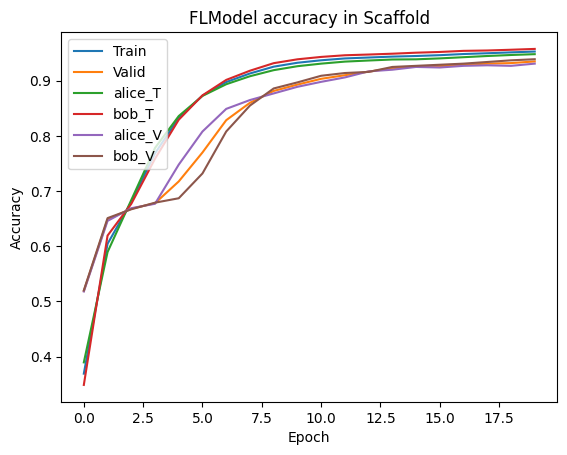

In [10]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history['global_history']['multiclassaccuracy'])
plt.plot(history['global_history']['val_multiclassaccuracy'])
plt.plot(history['local_history']['alice_train_multiclassaccuracy'])
plt.plot(history['local_history']['bob_train_multiclassaccuracy'])
plt.plot(history['local_history']['alice_val_eval_multiclassaccuracy'])
plt.plot(history['local_history']['bob_val_eval_multiclassaccuracy'])
plt.title('FLModel accuracy in Scaffold')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid','alice_T','bob_T','alice_V','bob_V'], loc='upper left')
plt.show()

In [11]:
fl_model_2 = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    aggregator=aggregator,
    # strategy='fed_avg_w',  # fl strategy
    strategy='fed_avg_w',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
)
history_2 = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=128,
    aggregate_freq=10,
)

INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.torch.strategy.fed_avg_w.PYUFedAvgW'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd75e1f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd702310>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd7674f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd702a90>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fd0cd7022b0>

Epoch 1/20


Train Processing: :  85%|████████▌ | 40/47 [00:00<00:00, 78.09it/s]WARNING:root:Please pay attention to local metrics, global only do naive aggregation 
(pid=1706945) 2023-12-08 13:19:56.610203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(pid=1707010) 2023-12-08 13:19:56.690122: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
Train Processing: :  85%|████████▌ | 40/47 [00:01<00:00, 23.83it/s, {'multiclassaccuracy': 0.9540833, 'multiclassprecision': 0.9540833, 'val_multiclassaccuracy': 0.936, 'val_multiclassprecision': 0.936}]
(pid=1706945) 2023-12-08 13:19:57.229432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not 

Epoch 2/20
(PYUScaffold pid=1701245) {'train-loss': 0.13577118515968323, 'train_multiclassaccuracy': tensor(0.9492), 'train_multiclassprecision': tensor(0.9492), 'val_eval_multiclassaccuracy': tensor(0.9320), 'val_eval_multiclassprecision': tensor(0.9320)}
(PYUScaffold pid=1701310) {'train-loss': 0.1920224279165268, 'train_multiclassaccuracy': tensor(0.9590), 'train_multiclassprecision': tensor(0.9590), 'val_eval_multiclassaccuracy': tensor(0.9400), 'val_eval_multiclassprecision': tensor(0.9400)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/20
(PYUScaffold pid=1701245) {'train-loss': 0.13222242891788483, 'train_multiclassaccuracy': tensor(0.9497), 'train_multiclassprecision': tensor(0.9497), 'val_eval_multiclassaccuracy': tensor(0.9330), 'val_eval_multiclassprecision': tensor(0.9330)}
(PYUScaffold pid=1701310) {'train-loss': 0.18845884501934052, 'train_multiclassaccuracy': tensor(0.9600), 'train_multiclassprecision': tensor(0.9600), 'val_eval_multiclassaccuracy': tensor(0.9400), 'val_eval_multiclassprecision': tensor(0.9400)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/20
(PYUScaffold pid=1701245) {'train-loss': 0.128944531083107, 'train_multiclassaccuracy': tensor(0.9497), 'train_multiclassprecision': tensor(0.9497), 'val_eval_multiclassaccuracy': tensor(0.9340), 'val_eval_multiclassprecision': tensor(0.9340)}
(PYUScaffold pid=1701310) {'train-loss': 0.1851329505443573, 'train_multiclassaccuracy': tensor(0.9607), 'train_multiclassprecision': tensor(0.9607), 'val_eval_multiclassaccuracy': tensor(0.9380), 'val_eval_multiclassprecision': tensor(0.9380)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/20
(PYUScaffold pid=1701245) {'train-loss': 0.1259308010339737, 'train_multiclassaccuracy': tensor(0.9502), 'train_multiclassprecision': tensor(0.9502), 'val_eval_multiclassaccuracy': tensor(0.9340), 'val_eval_multiclassprecision': tensor(0.9340)}
(PYUScaffold pid=1701310) {'train-loss': 0.18202635645866394, 'train_multiclassaccuracy': tensor(0.9610), 'train_multiclassprecision': tensor(0.9610), 'val_eval_multiclassaccuracy': tensor(0.9390), 'val_eval_multiclassprecision': tensor(0.9390)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6/20
(PYUScaffold pid=1701245) {'train-loss': 0.12314368039369583, 'train_multiclassaccuracy': tensor(0.9520), 'train_multiclassprecision': tensor(0.9520), 'val_eval_multiclassaccuracy': tensor(0.9370), 'val_eval_multiclassprecision': tensor(0.9370)}
(PYUScaffold pid=1701310) {'train-loss': 0.1791497766971588, 'train_multiclassaccuracy': tensor(0.9617), 'train_multiclassprecision': tensor(0.9617), 'val_eval_multiclassaccuracy': tensor(0.9420), 'val_eval_multiclassprecision': tensor(0.9420)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7/20
(PYUScaffold pid=1701245) {'train-loss': 0.12058638781309128, 'train_multiclassaccuracy': tensor(0.9527), 'train_multiclassprecision': tensor(0.9527), 'val_eval_multiclassaccuracy': tensor(0.9380), 'val_eval_multiclassprecision': tensor(0.9380)}
(PYUScaffold pid=1701310) {'train-loss': 0.17638851702213287, 'train_multiclassaccuracy': tensor(0.9625), 'train_multiclassprecision': tensor(0.9625), 'val_eval_multiclassaccuracy': tensor(0.9420), 'val_eval_multiclassprecision': tensor(0.9420)}


Train Processing: :  85%|████████▌ | 40/47 [00:01<00:00, 21.90it/s, {'multiclassaccuracy': 0.95766664, 'multiclassprecision': 0.95766664, 'val_multiclassaccuracy': 0.9405, 'val_multiclassprecision': 0.9405}]


(PYUScaffold pid=1701245) {'train-loss': 0.11822126805782318, 'train_multiclassaccuracy': tensor(0.9527), 'train_multiclassprecision': tensor(0.9527), 'val_eval_multiclassaccuracy': tensor(0.9380), 'val_eval_multiclassprecision': tensor(0.9380)}
(PYUScaffold pid=1701310) {'train-loss': 0.1739039421081543, 'train_multiclassaccuracy': tensor(0.9627), 'train_multiclassprecision': tensor(0.9627), 'val_eval_multiclassaccuracy': tensor(0.9430), 'val_eval_multiclassprecision': tensor(0.9430)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8/20


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 9/20
(PYUScaffold pid=1701245) {'train-loss': 0.11599421501159668, 'train_multiclassaccuracy': tensor(0.9533), 'train_multiclassprecision': tensor(0.9533), 'val_eval_multiclassaccuracy': tensor(0.9390), 'val_eval_multiclassprecision': tensor(0.9390)}
(PYUScaffold pid=1701310) {'train-loss': 0.17143049836158752, 'train_multiclassaccuracy': tensor(0.9633), 'train_multiclassprecision': tensor(0.9633), 'val_eval_multiclassaccuracy': tensor(0.9440), 'val_eval_multiclassprecision': tensor(0.9440)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 10/20
(PYUScaffold pid=1701245) {'train-loss': 0.11388691514730453, 'train_multiclassaccuracy': tensor(0.9535), 'train_multiclassprecision': tensor(0.9535), 'val_eval_multiclassaccuracy': tensor(0.9390), 'val_eval_multiclassprecision': tensor(0.9390)}
(PYUScaffold pid=1701310) {'train-loss': 0.16902029514312744, 'train_multiclassaccuracy': tensor(0.9635), 'train_multiclassprecision': tensor(0.9635), 'val_eval_multiclassaccuracy': tensor(0.9450), 'val_eval_multiclassprecision': tensor(0.9450)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 11/20
(PYUScaffold pid=1701245) {'train-loss': 0.11193637549877167, 'train_multiclassaccuracy': tensor(0.9540), 'train_multiclassprecision': tensor(0.9540), 'val_eval_multiclassaccuracy': tensor(0.9390), 'val_eval_multiclassprecision': tensor(0.9390)}
(PYUScaffold pid=1701310) {'train-loss': 0.16644349694252014, 'train_multiclassaccuracy': tensor(0.9645), 'train_multiclassprecision': tensor(0.9645), 'val_eval_multiclassaccuracy': tensor(0.9460), 'val_eval_multiclassprecision': tensor(0.9460)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 12/20
(PYUScaffold pid=1701245) {'train-loss': 0.11010897159576416, 'train_multiclassaccuracy': tensor(0.9545), 'train_multiclassprecision': tensor(0.9545), 'val_eval_multiclassaccuracy': tensor(0.9410), 'val_eval_multiclassprecision': tensor(0.9410)}
(PYUScaffold pid=1701310) {'train-loss': 0.16400551795959473, 'train_multiclassaccuracy': tensor(0.9647), 'train_multiclassprecision': tensor(0.9647), 'val_eval_multiclassaccuracy': tensor(0.9510), 'val_eval_multiclassprecision': tensor(0.9510)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 13/20
(PYUScaffold pid=1701245) {'train-loss': 0.10839957743883133, 'train_multiclassaccuracy': tensor(0.9555), 'train_multiclassprecision': tensor(0.9555), 'val_eval_multiclassaccuracy': tensor(0.9410), 'val_eval_multiclassprecision': tensor(0.9410)}
(PYUScaffold pid=1701310) {'train-loss': 0.1616896390914917, 'train_multiclassaccuracy': tensor(0.9647), 'train_multiclassprecision': tensor(0.9647), 'val_eval_multiclassaccuracy': tensor(0.9520), 'val_eval_multiclassprecision': tensor(0.9520)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 14/20
(PYUScaffold pid=1701245) {'train-loss': 0.10687923431396484, 'train_multiclassaccuracy': tensor(0.9560), 'train_multiclassprecision': tensor(0.9560), 'val_eval_multiclassaccuracy': tensor(0.9400), 'val_eval_multiclassprecision': tensor(0.9400)}
(PYUScaffold pid=1701310) {'train-loss': 0.1594959795475006, 'train_multiclassaccuracy': tensor(0.9652), 'train_multiclassprecision': tensor(0.9652), 'val_eval_multiclassaccuracy': tensor(0.9540), 'val_eval_multiclassprecision': tensor(0.9540)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 15/20
(PYUScaffold pid=1701245) {'train-loss': 0.10538548231124878, 'train_multiclassaccuracy': tensor(0.9567), 'train_multiclassprecision': tensor(0.9567), 'val_eval_multiclassaccuracy': tensor(0.9410), 'val_eval_multiclassprecision': tensor(0.9410)}
(PYUScaffold pid=1701310) {'train-loss': 0.15730714797973633, 'train_multiclassaccuracy': tensor(0.9653), 'train_multiclassprecision': tensor(0.9653), 'val_eval_multiclassaccuracy': tensor(0.9550), 'val_eval_multiclassprecision': tensor(0.9550)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 16/20
(PYUScaffold pid=1701245) {'train-loss': 0.10399412363767624, 'train_multiclassaccuracy': tensor(0.9573), 'train_multiclassprecision': tensor(0.9573), 'val_eval_multiclassaccuracy': tensor(0.9420), 'val_eval_multiclassprecision': tensor(0.9420)}
(PYUScaffold pid=1701310) {'train-loss': 0.15521545708179474, 'train_multiclassaccuracy': tensor(0.9662), 'train_multiclassprecision': tensor(0.9662), 'val_eval_multiclassaccuracy': tensor(0.9550), 'val_eval_multiclassprecision': tensor(0.9550)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 17/20
(PYUScaffold pid=1701245) {'train-loss': 0.10267738252878189, 'train_multiclassaccuracy': tensor(0.9575), 'train_multiclassprecision': tensor(0.9575), 'val_eval_multiclassaccuracy': tensor(0.9410), 'val_eval_multiclassprecision': tensor(0.9410)}
(PYUScaffold pid=1701310) {'train-loss': 0.15296317636966705, 'train_multiclassaccuracy': tensor(0.9667), 'train_multiclassprecision': tensor(0.9667), 'val_eval_multiclassaccuracy': tensor(0.9550), 'val_eval_multiclassprecision': tensor(0.9550)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 18/20
(PYUScaffold pid=1701245) {'train-loss': 0.10142731666564941, 'train_multiclassaccuracy': tensor(0.9578), 'train_multiclassprecision': tensor(0.9578), 'val_eval_multiclassaccuracy': tensor(0.9410), 'val_eval_multiclassprecision': tensor(0.9410)}
(PYUScaffold pid=1701310) {'train-loss': 0.15053021907806396, 'train_multiclassaccuracy': tensor(0.9668), 'train_multiclassprecision': tensor(0.9668), 'val_eval_multiclassaccuracy': tensor(0.9550), 'val_eval_multiclassprecision': tensor(0.9550)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 19/20
(PYUScaffold pid=1701245) {'train-loss': 0.10023534297943115, 'train_multiclassaccuracy': tensor(0.9578), 'train_multiclassprecision': tensor(0.9578), 'val_eval_multiclassaccuracy': tensor(0.9410), 'val_eval_multiclassprecision': tensor(0.9410)}
(PYUScaffold pid=1701310) {'train-loss': 0.14822335541248322, 'train_multiclassaccuracy': tensor(0.9670), 'train_multiclassprecision': tensor(0.9670), 'val_eval_multiclassaccuracy': tensor(0.9550), 'val_eval_multiclassprecision': tensor(0.9550)}


Train Processing: :   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 20/20
(PYUScaffold pid=1701245) {'train-loss': 0.09904652833938599, 'train_multiclassaccuracy': tensor(0.9582), 'train_multiclassprecision': tensor(0.9582), 'val_eval_multiclassaccuracy': tensor(0.9420), 'val_eval_multiclassprecision': tensor(0.9420)}
(PYUScaffold pid=1701310) {'train-loss': 0.14595261216163635, 'train_multiclassaccuracy': tensor(0.9672), 'train_multiclassprecision': tensor(0.9672), 'val_eval_multiclassaccuracy': tensor(0.9550), 'val_eval_multiclassprecision': tensor(0.9550)}


Train Processing: :  85%|████████▌ | 40/47 [00:02<00:00, 15.50it/s, {'multiclassaccuracy': 0.9628333, 'multiclassprecision': 0.9628333, 'val_multiclassaccuracy': 0.9485, 'val_multiclassprecision': 0.9485}]


In [12]:
print(history['local_history'])

(PYUScaffold pid=1701245) {'train-loss': 0.09788329154253006, 'train_multiclassaccuracy': tensor(0.9583), 'train_multiclassprecision': tensor(0.9583), 'val_eval_multiclassaccuracy': tensor(0.9420), 'val_eval_multiclassprecision': tensor(0.9420)}
(PYUScaffold pid=1701310) {'train-loss': 0.14375951886177063, 'train_multiclassaccuracy': tensor(0.9673), 'train_multiclassprecision': tensor(0.9673), 'val_eval_multiclassaccuracy': tensor(0.9550), 'val_eval_multiclassprecision': tensor(0.9550)}
{'alice_train-loss': [1.674750566482544, 1.2351067066192627, 0.9369772672653198, 0.7038540244102478, 0.530692994594574, 0.41198447346687317, 0.3367486894130707, 0.28798559308052063, 0.2543577253818512, 0.22985294461250305, 0.21124516427516937, 0.19664593040943146, 0.1849122792482376, 0.1752168834209442, 0.16704824566841125, 0.16007672250270844, 0.15404614806175232, 0.1487196981906891, 0.1439419686794281, 0.13964541256427765], 'alice_train_multiclassaccuracy': [tensor(0.3895), tensor(0.5895), tensor(0.68

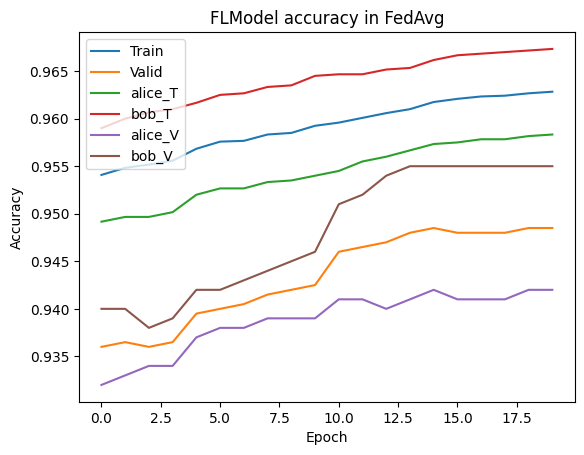

In [13]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history_2['global_history']['multiclassaccuracy'])
plt.plot(history_2['global_history']['val_multiclassaccuracy'])
plt.plot(history_2['local_history']['alice_train_multiclassaccuracy'])
plt.plot(history_2['local_history']['bob_train_multiclassaccuracy'])
plt.plot(history_2['local_history']['alice_val_eval_multiclassaccuracy'])
plt.plot(history_2['local_history']['bob_val_eval_multiclassaccuracy'])
plt.title('FLModel accuracy in FedAvg')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid','alice_T','bob_T','alice_V','bob_V'], loc='upper left')
plt.show()